In [ ]:
# to load, you'll need to do:
Pkg.clone("https://github.com/tbreloff/Julia.jl")
Pkg.checkout("Julia", "tb_github")

In [1]:
# load in the stargazers table
using DataFrames
df = readtable(Pkg.dir("Julia","stargazers.csv"))
head(df,2)

,repo,url,gazers,group,subgroup
1,BackpropNeuralNet,compressed/BackpropNeuralNet.jl,"(Any[johnmyleswhite,intltechventures,flashus,sorami,vimeitor,jskDr,meekrabR6R,0xmilk,bernatfp,phelma,alexanderpanchenko,huwenshuo,darmat,rkwofford,papaloizouc,rredpoppy,abrazhe,seaskyshy,skariel,dmoliveira,cpminor,matthew-lake,HHzzhz,chrisidefix,mertyildiran,LuciusCao,konfou,bunnyblanco,cameronraysmith,diegozea],)",AI,MACHINELEARNING
2,BNMF,r9y9/BNMF.jl,"(Any[knoike],)",AI,MACHINELEARNING


In [2]:
# count the stargazers, add a column to the table, then sort from most to least
getgazers(i) = split(df[i,:gazers][6:end-3], ",")
starcounts = map(i->length(getgazers(i)), 1:size(df,1));
df[:gscount] = starcounts
sort!(df, rev=true, cols=[:gscount])
head(df,2)

2×6 DataFrames.DataFrame
│ Row │ repo         │ url                        │
├─────┼──────────────┼────────────────────────────┤
│ 1   │ "Mocha"      │ "pluskid/Mocha.jl"         │
│ 2   │ "DataFrames" │ "JuliaStats/DataFrames.jl" │

│ Row │ gazers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [3]:
N = length(unique(df[:group]))
groupnames = sort(unique(df[:group]))'

1x23 DataArrays.DataArray{UTF8String,2}:
 "AI"  "API"  "Algorithms"  "Biology"  …  "Utilities"  "i18n-L10n"

[Plots.jl] Initializing backend: pyplot



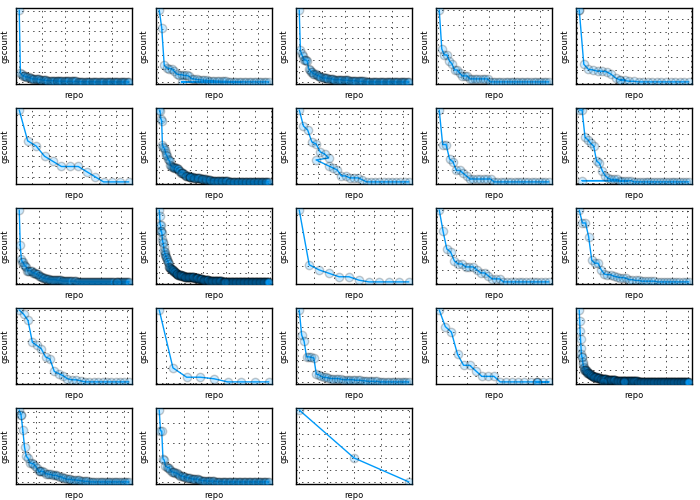

In [4]:
using PlotRecipes
pyplot(size=(700,500), leg=false, guidefont=font(6), titlefont=font(9))
p = plot(df, :repo, :gscount, group=:group, layout=N, ticks=nothing, marker=(6,0.2))


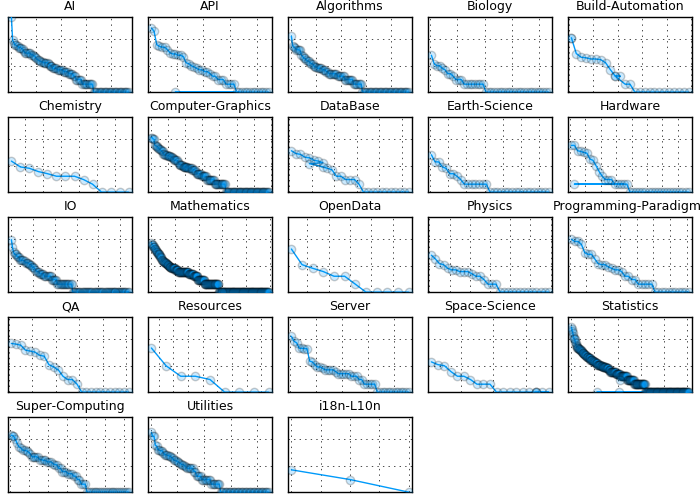

In [5]:
plot!(title = groupnames, yscale=:log, ylink = 1:N, guide="")

In [6]:
groups, subgroups, repos = df[:group], df[:subgroup], df[:repo];
groupfilter(gname) = filter(i -> groups[i] == gname, 1:length(groups))

groupfilter (generic function with 1 method)


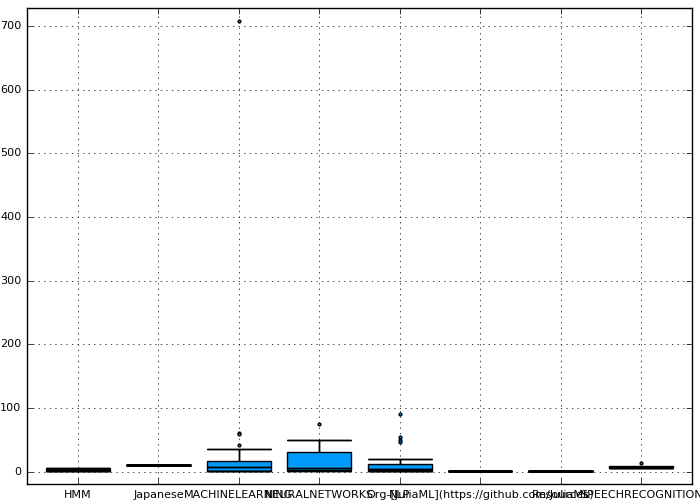

In [7]:
boxplot(subgroups, starcounts, markersize = 2, idxfilter=groupfilter("AI"))


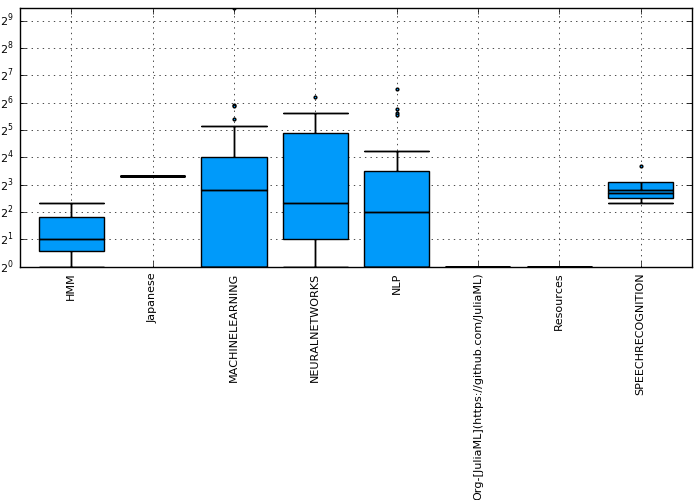

/home/tom/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/numpy/ma/core.py:2077: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xf >= v1) & (xf <= v2)
/home/tom/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/numpy/ma/core.py:2077: RuntimeWarning: invalid value encountered in less_equal
  condition = (xf >= v1) & (xf <= v2)
/home/tom/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/numpy/ma/core.py:812: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/tom/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/numpy/ma/core.py:827: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)


In [8]:
plot!(yscale=:log2, xrot=90)


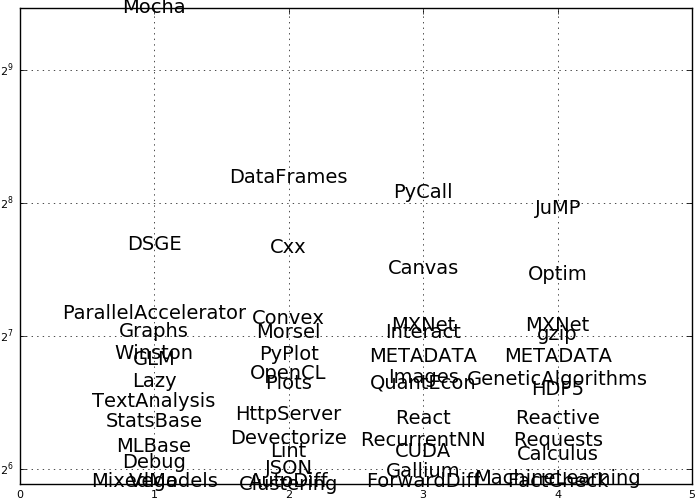

In [10]:
# cycling inputs, series annotations
n = 50
plot(1:4, starcounts[1:n], xlim=(0,5), w=0, series_annotations=repos[1:n], yscale=:log2)

In [11]:
# PlotText construction
text("Hi",10)

/home/tom/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Plots.PlotText("Hi",Plots.Font("Helvetica",10,:hcenter,:vcenter,0.0,RGB{U8}(0.0,0.0,0.0)))


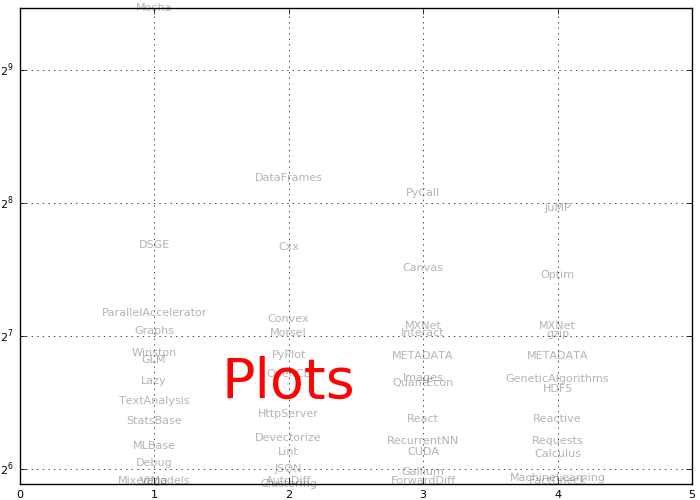

In [13]:
# text attributes
idx = findfirst(repos, "Plots")
anns = [repo == "Plots" ? text(repo,40,:red) : text(repo,8,RGBA(0,0,0,0.3)) for repo in repos[1:n]]
plot(1:4, starcounts[1:n], xlim=(0,5), w=0, yscale=:log2, series_annotations=anns)

In [56]:
v = []
for i=1:20
    repo = df[i,:repo]
    gs = getgazers(i)
    @show repo,length(gs)
    push!(v, [(length(gs), repo, gs)])
end
v

(repo,length(gs)) = ("BackpropNeuralNet",30)
(repo,length(gs)) = ("BNMF",1)
(repo,length(gs)) = ("ConfidenceWeighted",1)
(repo,length(gs)) = ("Contingency",1)
(repo,length(gs)) = ("Clustering",59)
(repo,length(gs)) = ("DAI",2)
(repo,length(gs)) = ("DeepQLearning",17)
(repo,length(gs)) = ("Discretizers",2)
(repo,length(gs)) = ("EGR",1)
(repo,length(gs)) = ("ELM",22)
(repo,length(gs)) = ("FeatureSelection",1)
(repo,length(gs)) = ("Flimsy",1)
(repo,length(gs)) = ("FunctionalDataUtils",4)
(repo,length(gs)) = ("go",1)
(repo,length(gs)) = ("GradientBoost",7)
(repo,length(gs)) = ("GURLS",1)
(repo,length(gs)) = ("Glmnet",30)
(repo,length(gs)) = ("HopfieldNets",10)
(repo,length(gs)) = ("HSIC",2)
(repo,length(gs)) = ("KaggleDigitRecognizer",1)


20-element Array{Any,1}:
 [(30,"BackpropNeuralNet",SubString{UTF8String}["johnmyleswhite","intltechventures","flashus","sorami","vimeitor","jskDr","meekrabR6R","0xmilk","bernatfp","phelma"  …  "cpminor","matthew-lake","HHzzhz","chrisidefix","mertyildiran","LuciusCao","konfou","bunnyblanco","cameronraysmith","diegozea"])]    
 [(1,"BNMF",SubString{UTF8String}["knoike"])]                                                                                                                                                                                                                                                                
 [(1,"ConfidenceWeighted",SubString{UTF8String}["vishalbelsare"])]                                                                                                                                                                                                                                           
 [(1,"Contingency",SubString{UTF8String}[""])]                       

In [57]:
sort(v)

LoadError: LoadError: MethodError: `isless` has no method matching isless(::Array{Tuple{Int64,UTF8String,Array{SubString{UTF8String},1}},1}, ::Array{Tuple{Int64,UTF8String,Array{SubString{UTF8String},1}},1})
Closest candidates are:
  isless(!Matched::DataArrays.NAtype, ::Any)
  isless(::Any, !Matched::DataArrays.NAtype)
while loading In[57], in expression starting on line 1